# imports

In [1]:
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# impute.imputer
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # pd.get_dummies
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA
# stats : R module
from scipy.stats import skew, kurtosis

# estimators ---------------------------------------
# estimators.classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # classifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV # regressor 응용
# estimators.regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
# --------------------------------------------------

# neural network -----------------------------------
import tensorflow as tf
import keras
# --------------------------------------------------

# ensemble -----------------------------------------
# ensemble.bagging
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# ensemble.boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
# ensemble.boosting & bagging
from xgboost import XGBRFClassifier, XGBRFRegressor
# ensemble.voting
from sklearn.ensemble import VotingClassifier, VotingRegressor
# --------------------------------------------------

# metrics ------------------------------------------
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# --------------------------------------------------

# model_selection ----------------------------------
# model_selection.splitter
from sklearn.model_selection import train_test_split
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV
# --------------------------------------------------

# optuna -------------------------------------------
import optuna
# --------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm

from IPython.core.display import display, HTML
# display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

plt.rcParams['font.family'] = 'Malgun Gothic'

# read

In [3]:
cus   = pd.read_csv('./data/cus_info.csv')
iem   = pd.read_csv('./data/iem_info_20210902.csv')
hist  = pd.read_csv('./data/stk_bnc_hist.csv')
train = pd.read_csv('./data/stk_hld_train.csv')
test  = pd.read_csv('./data/stk_hld_test.csv')
sub   = pd.read_csv('./data/sample_submission.csv')

# EDA

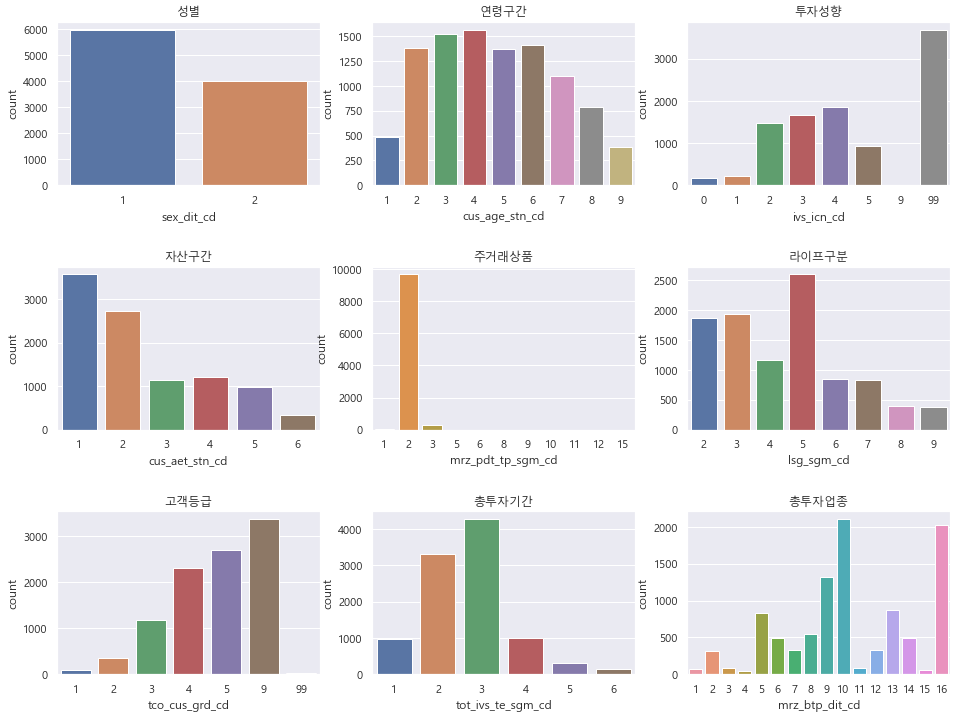

In [4]:
cus_cols = ['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd']
cols     = ['성별', '연령구간', '투자성향', '자산구간', '주거래상품', '라이프구분', '고객등급', '총투자기간', '총투자업종']    

fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols):
    r = i // 3
    c = i % 3
    sns.countplot(col, data=cus, ax=ax[r, c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

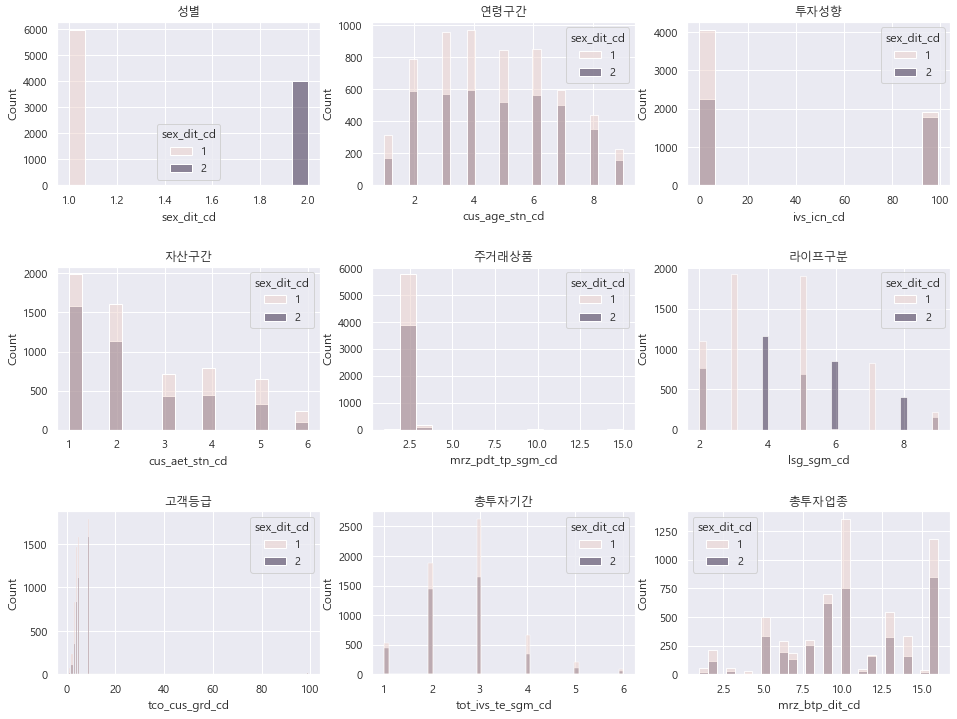

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, col in enumerate(cus_cols) :
    r = i // 3
    c = i % 3
    sns.histplot(data=cus, x=col, hue='sex_dit_cd', ax=ax[r ,c])
    ax[r, c].set_title(f'{cols[i]}')
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# feature engineering

## cus.ivs_icn_cd : 투자성향

In [6]:
# 투자성향 미정의(99) 비율 0.3687 : drop
print(cus[cus['ivs_icn_cd'] == 99].shape[0] / cus.shape[0])
cus.drop('ivs_icn_cd', axis=1, inplace=True)

0.3687


## cus.lsg_sgm_cd : life stage

In [7]:
# 연령과 성별 변수 포함 : drop
cus.drop('lsg_sgm_cd', axis=1, inplace=True)

## cus.tco_cus_grd_cd : 고객등급

In [8]:
# 서비스 등급 결측치(99)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 1)] = 3 # 1억 이상, 3억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 99) & (cus['cus_aet_stn_cd'] == 2)] = 3 # 1억 이상, 3억 미만

# 서비스 등급 미정의(9)를 자산구간별으로 분배
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 1)] = 9 # 1천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 2)] = 5 # 1천 이상, 3천 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 3)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 4)] = 4 # 3천 이상, 1억 미만
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9) & (cus['cus_aet_stn_cd'] == 5)] = 3 # 1억 이상, 3억 미만

# 이외의 서비스 등급 미정의(9)는 고객등급 6으로 설정
cus['tco_cus_grd_cd'][(cus['tco_cus_grd_cd'] == 9)] = 6

<AxesSubplot:>

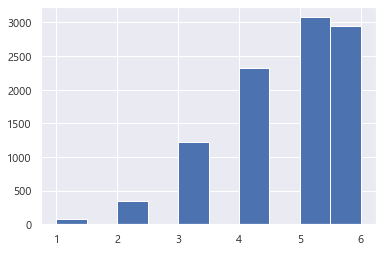

In [9]:
cus['tco_cus_grd_cd'].hist()

## iem.mkt_pr_tal_scl_tp_cd : 시총규모

In [10]:
# 기타(99) -> 3
iem['mkt_pr_tal_scl_tp_cd'][iem['mkt_pr_tal_scl_tp_cd'] == 99] = 3

## iem.stk_dit_cd : 시장구분

In [11]:
# 기타(99) -> 3
iem['stk_dit_cd'][iem['stk_dit_cd'] == 99] = 3

## hist.stk_p : 매매 평균단가

In [12]:
hist['stk_p'] = hist['tot_aet_amt'] / hist['bnc_qty']
hist['stk_p'].fillna(0, inplace=True)

## train.hist_d

In [13]:
train['hist_d'] = np.trunc(train['hold_d'] * 0.7)

# merge

## cus & iem

In [14]:
train_data = pd.merge(train, cus, how='left', on='act_id')
train_data = pd.merge(train_data, iem, how='left', on='iem_cd')

test_data = pd.merge(test, cus, how='left', on='act_id')
test_data = pd.merge(test_data, iem, how='left', on='iem_cd')

## hist

In [15]:
train_data = pd.merge(train_data, hist, how='left', on=['act_id', 'iem_cd'])
train_data = train_data[(train_data['byn_dt'] == train_data['bse_dt'])]

test_data = pd.merge(test_data, hist, how = 'left', on=['act_id', 'iem_cd'])
test_data = test_data[(test_data['byn_dt'] == test_data['bse_dt'])]

In [16]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# encode

In [17]:
le = LabelEncoder()
le.fit(iem['iem_krl_nm'])
train_data['iem_krl_nm'] = le.transform(train_data['iem_krl_nm'])
test_data['iem_krl_nm']  = le.transform(test_data['iem_krl_nm'])

# drop

In [18]:
train_data.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt'], axis=1, inplace=True)
test_data.drop(['act_id', 'iem_cd', 'byn_dt', 'bse_dt', 'submit_id', 'hold_d'], axis=1, inplace=True)

In [19]:
train_data

,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,11,7.0,1,9,2,2,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,80,56.0,1,9,2,2,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,5,3.0,1,9,2,2,5,5,8,2530,12,2,3,786.0,14619600.0,1000.0,18600.0
3,22,15.0,1,9,2,2,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,324,226.0,1,9,2,2,5,5,8,1696,10,3,3,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,1,0.0,1,4,2,2,4,3,8,1752,10,3,3,199.0,3532250.0,500.0,17750.0
681468,1,0.0,1,4,2,2,4,3,8,2344,8,2,3,488.0,22960400.0,500.0,47050.0
681469,1,0.0,1,4,2,2,4,3,8,521,2,2,3,2210.0,9204650.0,500.0,4165.0
681470,1,0.0,1,4,2,2,4,3,8,2460,2,3,3,285.0,2721750.0,500.0,9550.0


In [20]:
train_data.shape, test_data.shape

((681472, 17), (70596, 16))

# scale

In [21]:
rbs = RobustScaler()

rbs.fit(train_data[test_data.columns])
train_data[test_data.columns] = rbs.transform(train_data[test_data.columns])
test_data[test_data.columns]  = rbs.transform(test_data[test_data.columns])

In [22]:
train_data['hold_d'] = np.log1p(train_data['hold_d'])

# score

In [23]:
X_train_data = train_data.drop('hold_d', axis=1)
y_train_data = train_data['hold_d']

In [24]:
# models = []

# folds = KFold(n_splits=10)
# for train_idx, val_idx in folds.split(X_train_data):
    
#     train_x = X_train_data.iloc[train_idx, :]
#     train_y = y_train_data[train_idx]
#     val_x = X_train_data.iloc[val_idx, :]
#     val_y = y_train_data[val_idx]
    
#     model = CatBoostRegressor(random_state=0)
#     # LGBMRegressor(objective= "regression",
#     #                       max_depth= 5,
#     #                       n_estimators= 2000,
#     #                       learning_rate= 0.01,
#     #                       num_leaves = 31,
#     #                       random_state=0)
    
#     model.fit(train_x, train_y,
#               eval_set=[(val_x, val_y)],
#             #   eval_metric=["rmse"],
#               early_stopping_rounds=300,
#               verbose=500)
    
#     models.append(model)

In [25]:
estimator = CatBoostRegressor()

param_distributions = {
    'iterations'   :optuna.distributions.IntUniformDistribution(1000, 5000), 
    'learning_rate':optuna.distributions.UniformDistribution(0.01, 0.9),
    }

optuna_search = optuna.integration.OptunaSearchCV(
    estimator, 
    param_distributions, 
    cv=5, 
    random_state=0,
    return_train_score=True,
    scoring='neg_root_mean_squared_error',
    verbose=500,
    timeout=43200,
    )

optuna_search.fit(X_train_data, y_train_data)

print(optuna_search.best_score_)
print(optuna_search.best_estimator_)
print(optuna_search.best_params_)

[I 2021-10-10 21:57:18,307] A new study created in memory with name: no-name-9961c590-1ef2-4b82-a66d-a9cfbec29aad
[I 2021-10-10 21:57:18,309] Searching the best hyperparameters using 681472 samples...


0:	learn: 0.5225565	total: 197ms	remaining: 9m 40s
1:	learn: 0.2303054	total: 253ms	remaining: 6m 12s
2:	learn: 0.1271062	total: 309ms	remaining: 5m 3s
3:	learn: 0.0930992	total: 367ms	remaining: 4m 29s
4:	learn: 0.0807807	total: 417ms	remaining: 4m 5s
5:	learn: 0.0743124	total: 469ms	remaining: 3m 49s
6:	learn: 0.0629019	total: 543ms	remaining: 3m 47s
7:	learn: 0.0609096	total: 591ms	remaining: 3m 36s
8:	learn: 0.0571930	total: 649ms	remaining: 3m 31s
9:	learn: 0.0526929	total: 709ms	remaining: 3m 28s
10:	learn: 0.0513780	total: 767ms	remaining: 3m 24s
11:	learn: 0.0503012	total: 813ms	remaining: 3m 18s
12:	learn: 0.0495377	total: 871ms	remaining: 3m 16s
13:	learn: 0.0488698	total: 926ms	remaining: 3m 13s
14:	learn: 0.0484581	total: 1.02s	remaining: 3m 18s
15:	learn: 0.0477316	total: 1.09s	remaining: 3m 19s
16:	learn: 0.0473861	total: 1.16s	remaining: 3m 19s
17:	learn: 0.0471252	total: 1.21s	remaining: 3m 16s
18:	learn: 0.0469080	total: 1.25s	remaining: 3m 13s
19:	learn: 0.0465882	tot

[I 2021-10-10 22:10:17,129] Trial 0 finished with value: -0.0472863752737497 and parameters: {'iterations': 2944, 'learning_rate': 0.62028396258481}. Best is trial 0 with value: -0.0472863752737497.


0:	learn: 1.0246337	total: 107ms	remaining: 8m 50s
1:	learn: 0.8411873	total: 173ms	remaining: 7m 6s
2:	learn: 0.6918150	total: 229ms	remaining: 6m 17s
3:	learn: 0.5695283	total: 276ms	remaining: 5m 40s
4:	learn: 0.4675457	total: 322ms	remaining: 5m 18s
5:	learn: 0.3856608	total: 372ms	remaining: 5m 5s
6:	learn: 0.3178925	total: 422ms	remaining: 4m 57s
7:	learn: 0.2627793	total: 466ms	remaining: 4m 47s
8:	learn: 0.2177668	total: 511ms	remaining: 4m 40s
9:	learn: 0.1807292	total: 557ms	remaining: 4m 34s
10:	learn: 0.1511157	total: 602ms	remaining: 4m 29s
11:	learn: 0.1271970	total: 646ms	remaining: 4m 25s
12:	learn: 0.1081724	total: 690ms	remaining: 4m 21s
13:	learn: 0.0932455	total: 733ms	remaining: 4m 18s
14:	learn: 0.0816912	total: 777ms	remaining: 4m 15s
15:	learn: 0.0726570	total: 822ms	remaining: 4m 13s
16:	learn: 0.0658884	total: 866ms	remaining: 4m 10s
17:	learn: 0.0608657	total: 909ms	remaining: 4m 8s
18:	learn: 0.0571661	total: 952ms	remaining: 4m 6s
19:	learn: 0.0546013	total

[I 2021-10-11 10:59:28,979] Trial 1 finished with value: -0.04573700528981368 and parameters: {'iterations': 4943, 'learning_rate': 0.18408080504437804}. Best is trial 1 with value: -0.04573700528981368.
[I 2021-10-11 10:59:28,980] Finished hyperparemeter search!
[I 2021-10-11 10:59:28,981] Refitting the estimator using 681472 samples...


0:	learn: 1.0406334	total: 97.2ms	remaining: 8m
1:	learn: 0.8558412	total: 189ms	remaining: 7m 47s
2:	learn: 0.7018760	total: 306ms	remaining: 8m 24s
3:	learn: 0.5771236	total: 404ms	remaining: 8m 19s
4:	learn: 0.4743437	total: 493ms	remaining: 8m 7s
5:	learn: 0.3910861	total: 591ms	remaining: 8m 6s
6:	learn: 0.3221046	total: 679ms	remaining: 7m 58s
7:	learn: 0.2663833	total: 767ms	remaining: 7m 52s
8:	learn: 0.2208942	total: 845ms	remaining: 7m 43s
9:	learn: 0.1838961	total: 923ms	remaining: 7m 35s
10:	learn: 0.1537289	total: 1s	remaining: 7m 29s
11:	learn: 0.1294613	total: 1.09s	remaining: 7m 27s
12:	learn: 0.1100068	total: 1.16s	remaining: 7m 21s
13:	learn: 0.0944520	total: 1.24s	remaining: 7m 16s
14:	learn: 0.0825417	total: 1.35s	remaining: 7m 24s
15:	learn: 0.0734031	total: 1.44s	remaining: 7m 21s
16:	learn: 0.0664160	total: 1.5s	remaining: 7m 15s
17:	learn: 0.0612194	total: 1.57s	remaining: 7m 9s
18:	learn: 0.0574374	total: 1.64s	remaining: 7m 4s
19:	learn: 0.0547588	total: 1.7s	

[I 2021-10-11 11:06:37,113] Finished refitting! (elapsed time: 428.131 sec.)


-0.04573700528981368
{'iterations': 4943, 'learning_rate': 0.18408080504437804}


In [26]:
predict = optuna_search.predict(test_data)

In [27]:
sub['hold_d'] = np.expm1(predict)
sub

,submit_id,hold_d
0,IDX00001,216.666397
1,IDX00002,480.980293
2,IDX00003,198.803848
3,IDX00004,339.366110
4,IDX00005,13.429375
...,...,...
70591,IDX70592,33.469356
70592,IDX70593,147.744267
70593,IDX70594,776.501580
70594,IDX70595,16.529566


# label check

In [28]:
temp = pd.merge(test.drop('hold_d', axis=1), sub, how='left', on='submit_id')

over_cond = temp['hist_d'] >= temp['hold_d']            # hist_d >= hold_d
under_cond = ((temp['hold_d'] - temp['hist_d']) > 146)  # (hold_d - hist_d) > 146

temp[over_cond | under_cond]

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
7,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395,A033320,20180126,720,IDX00008,868.975362
9,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395,A009580,20181206,510,IDX00010,718.854862
11,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097067e5b41a971afa1da,A000030,20160104,1227,IDX00012,905.811969
12,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097067e5b41a971afa1da,A316140,20190213,467,IDX00013,685.955805
21,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,A222390,20160104,1227,IDX00022,833.108444
...,...,...,...,...,...,...
64246,d3b5895a911070db62db021810ed18009689d81eb57865f5613913a46f3107f5,A003620,20190812,343,IDX64247,489.669065
64827,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af3323b383c202a212e550,A121890,20190711,365,IDX64828,522.160852
70580,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A117580,20160104,1227,IDX70581,838.864925
70588,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481fc34b2242b11b8a11c,A017670,20190723,357,IDX70589,510.967553


## (hold_d - hist_d) > 146 == hist_d + 146

In [29]:
over_idx = temp[over_cond].index.tolist()
len(over_idx)

298

In [30]:
sub.loc[over_idx, 'hold_d'] = temp.loc[over_idx, 'hist_d'] + 146

In [31]:
sub

,submit_id,hold_d
0,IDX00001,216.666397
1,IDX00002,480.980293
2,IDX00003,198.803848
3,IDX00004,339.366110
4,IDX00005,13.429375
...,...,...
70591,IDX70592,33.469356
70592,IDX70593,147.744267
70593,IDX70594,1004.000000
70594,IDX70595,16.529566


## hist_d < hold_d : hist_d + 1

In [32]:
under_idx = temp[under_cond].index.tolist()
len(under_idx)

4577

In [33]:
sub.loc[under_idx, 'hold_d'] = temp.loc[under_idx, 'hist_d'] + 1

In [34]:
sub

,submit_id,hold_d
0,IDX00001,216.666397
1,IDX00002,480.980293
2,IDX00003,198.803848
3,IDX00004,339.366110
4,IDX00005,13.429375
...,...,...
70591,IDX70592,33.469356
70592,IDX70593,147.744267
70593,IDX70594,1004.000000
70594,IDX70595,16.529566


# to_csv

In [36]:
# sub.to_csv('./sub/sub_pjh_10.csv', index=False)